In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import OneHotEncoder
from data_utils import *
from scipy import stats

In [2]:
import matplotlib.style as style
style.use('seaborn-notebook')
sns.set_palette("viridis")

In [3]:
df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

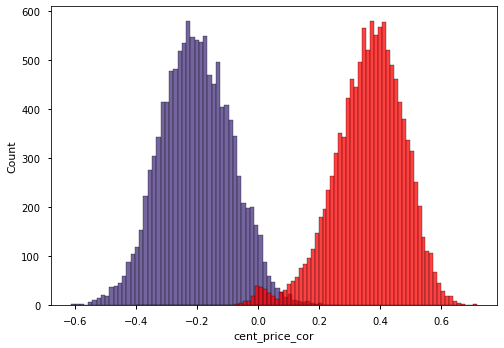

In [4]:
sns.histplot(data=df, x="cent_price_cor")
sns.histplot(data=df, x="cent_trans_cor", color='r')
df = df[df.cent_trans_cor> -0.38]

In [5]:
def feature_generation(df):
    df['g1']       = df['g1'].apply(np.sqrt)
    df['g2']       = df['g2'].apply(np.sqrt)

    
    df['e_avg'] = df.filter(regex=("e\d")).sum(axis=1)

    df['g_l'] = df['g1']*df['g2']*df['l3']*df['n']
    
    df['a_1_3'] = (df['a1']-df['a3'])
    df['a_1_3'] += np.abs(df['a_1_3'].min())+1
    
    df['c_1_3'] = (df['c1']-df['c3'])
    df['c_1_3'] += np.abs(df['c_1_3'].min())+1
    
    df['rf1'] = df['g_l']+df['a_1_3']
    df['rf2'] = df['c_1_3']-df['a_1_3']
    df['rf2'] += np.abs(df['rf2'].min())+1
    
    #df['coord_1'] = (df['x'] + df['y'] + df['z'])/3
    #df['coord_2'] = (df['x'] * df['y'] * df['z'])**(1./3)
    df['volume'] = df['x'] * df['y'] * df['z']
    df['floor_area'] = df['x'] * df['y']
    df['rf3'] = df['volume']*(df['g1']+.1)
    #df['density'] = df['volume'] / df['n']

    return df

# BoxCox
def normalize(df, df_test):
    for col in df.columns:
        if col not in ['cent_price_cor', 'cent_trans_cor', 'id']:
            df[col], lmbda = stats.boxcox(df[col]+0.1)
            df_test[col] = stats.boxcox(df_test[col]+0.1, lmbda=lmbda)
            
            scaler = RobustScaler()
            scaler.fit(df[col].values.reshape(-1,1))
            df[col] = scaler.transform(df[col].values.reshape(-1,1))
            df_test[col] = scaler.transform(df_test[col].values.reshape(-1,1))
    return df, df_test

# MinMax Scaling
def scale(df, df_test):
    for col in df.columns:
        if col not in ['cent_price_cor', 'cent_trans_cor', 'id'] :
            scaler = MinMaxScaler()
            scaler.fit(df[col].values.reshape(-1,1))
            df[col] = scaler.transform(df[col].values.reshape(-1,1))
            df_test[col] = scaler.transform(df_test[col].values.reshape(-1,1))
    return df, df_test

df = feature_generation(df)
df_test = feature_generation(df_test)
#df, df_test = scale(df, df_test)
df, df_test = normalize(df, df_test)


In [6]:
corrmat = df.corr(method='spearman')

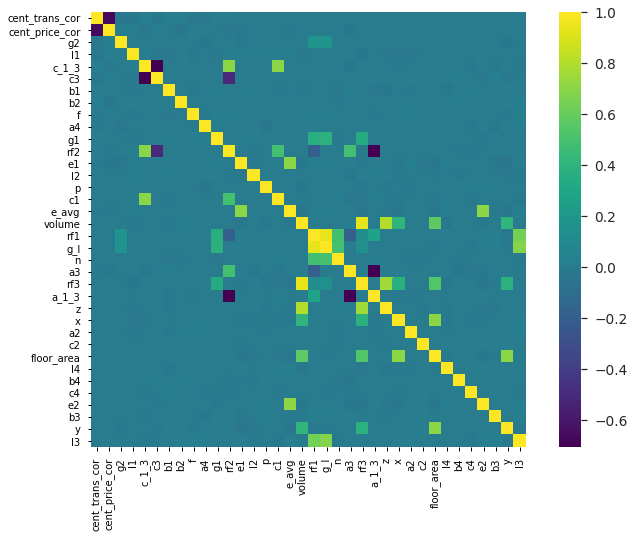

In [7]:
f, ax = plt.subplots(figsize=(12, 8))
k = 36 #number of variables for heatmap
cols = corrmat.abs().nlargest(k, 'cent_trans_cor')['cent_trans_cor'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap='viridis', cbar=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)

In [8]:
plot_var_histogram = False
plot_var_cor = False

if plot_var_histogram:
    fig, ax = plt.subplots(figsize=(35, 30))
    for i, col in enumerate(df.columns):
        plt.subplot(7,6,i+1)
        sns.histplot(data=df, x=col, bins=60, kde=True, palette='viridis')

if plot_var_cor:
    fig, ax = plt.subplots(figsize=(30, 30))
    for i, col in enumerate(df.columns):
        plt.subplot(7,6,i+1)
        sns.scatterplot(data=df, x=col, y='cent_trans_cor', palette='viridis')     


In [9]:
df = shuffle(df)
df.to_csv("data/f_train.csv", index=False)
df_test.to_csv("data/f_test.csv", index=False)

In [10]:
df.describe()

,n,p,f,x,y,z,a1,a2,a3,a4,...,cent_trans_cor,e_avg,g_l,a_1_3,c_1_3,rf1,rf2,volume,floor_area,rf3
count,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,...,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000,11939.000000
mean,-0.042844,-0.003807,-0.510740,-0.034693,-0.029026,0.042072,-0.023613,-0.001873,-0.036788,-0.016985,...,0.362649,-0.013880,-0.003105,-0.002098,-0.011683,0.030014,-0.013033,-0.016148,0.020940,-0.019868
std,0.587018,0.613772,0.962145,0.612666,0.613490,0.591927,0.583759,0.578508,0.583709,0.583078,...,0.115015,0.706252,0.691071,0.712693,0.685678,0.700149,0.721041,0.686920,0.686301,0.692357
min,-1.171590,-1.020985,-2.042345,-1.089274,-1.084710,-0.966945,-1.105885,-1.028196,-1.122778,-1.047744,...,-0.082000,-1.845031,-1.652884,-1.778438,-1.693070,-2.871028,-2.393131,-1.737390,-1.658143,-1.937749
25%,-0.537734,-0.504840,-1.000000,-0.518119,-0.517236,-0.433778,-0.519797,-0.506303,-0.522735,-0.510562,...,0.294000,-0.477289,-0.495325,-0.482987,-0.504374,-0.466153,-0.502329,-0.519616,-0.463014,-0.522495
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.372000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.462266,0.495160,0.000000,0.481881,0.482764,0.566222,0.480203,0.493697,0.477265,0.489438,...,0.443000,0.522711,0.504675,0.517013,0.495626,0.533847,0.497671,0.480384,0.536986,0.477505
max,0.913002,0.981876,0.967501,0.936695,0.939698,0.909157,0.932722,0.976851,0.923070,0.961490,...,0.717000,1.646190,1.880691,1.652445,1.587292,1.938621,2.212309,1.749555,1.521398,1.944866
